In [1]:
%load_ext autoreload
%autoreload 2

In [22]:
import matplotlib.pyplot as plt
import VeraRubin as vr
import numpy as np

from astropy.io import fits

In [23]:
def apply_correction_to_stamp(
        stamp_file,
        rotation_angle,
        output_path=None,
        keep_size=False,
        interp_order=3,
        update_wcs=True,
        c=1,
        from_data=False,
        warping_kernel='lanczos4',
        radius_pixels=120,  # new
        center_coord=None  # new
    ):
    """
    Rotate/Shift a FITS (Flexible Image Transport System) stamp image by a given angle (anticlockwise), optionally updating the WCS.

    Parameters:
    -----------
    stamp_file : str
        Path to the input FITS stamp.
    rotation_angle : float
        Rotation angle in degrees (anticlockwise).
    output_path : str
        Path to save the rotated FITS file.
    keep_size : bool
        If True, keeps the original image size (cropping or padding as needed).
    interp_order : int
        Interpolation order for rotation (0=nearest, 1=linear, 3=cubic).
    update_wcs : bool
        If True, rotate and update the WCS information in the header.
    from_data : bool
        if True used the function apply_correction_from_data else apply_correction_from_exposureF
    warping_kernel : str
        Interpolation kernel for warping. Options: "lanczos3", "bilinear", etc.

    Returns:
    --------
    str or astropy.io.fits.HDUList
        Path to the rotated FITS file if output_path is given, else HDU object.

    see:
    https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.rotate.html
    """
    try:
        # Load the original data and header
        with fits.open(stamp_file) as hdul:
            data = hdul[0].data.astype(np.float32, copy=False)  # Give the pixels of the first extension
            hdr = hdul[0].header.copy()  # Copy its metadata (header)
            # Note: The header may contain WCS (World Coordinate System) keywords such as:
            # NAXIS1, NAXIS2: size of the image in pixels along X and Y axes.
            # CRPIX1, CRPIX2: pixel coordinates of the reference point in the image.
            #                 This is the “anchor” pixel used for coordinate transformations.
            # CRVAL1, CRVAL2: celestial coordinates (RA/Dec in degrees) corresponding to the reference pixel (CRPIX1, CRPIX2).
            #                  They define the position on the sky that the reference pixel represents.
            # CDELT1, CDELT2: pixel scale in degrees per pixel along X and Y axes.
            #                  They are used to convert pixel offsets to sky coordinate offsets.
            # CTYPE1, CTYPE2: type of projection used for mapping the sky onto the image (e.g., 'TAN' for gnomonic, 'CAR' for Cartesian).
            #                  Determines how RA/Dec are computed for pixels away from the reference pixel.
            # etc.
            # Using these WCS parameters, the celestial coordinates (RA, Dec) of any pixel (x, y) can be calculated as:
            #   RA  = CRVAL1 + (x - CRPIX1) * CDELT1 (with projection applied by CTYPE1)
            #   Dec = CRVAL2 + (y - CRPIX2) * CDELT2 (with projection applied by CTYPE2)
            # This allows transforming pixel positions to accurate sky coordinates.

        exposure_ref = vr.fits_to_exposure(data, hdr)
        
        if from_data:
            rotated_data, hdr_new = vr.apply_correction_from_data(
                data, hdr, rotation_angle,
                keep_size=keep_size, interp_order=interp_order, update_wcs=update_wcs, c=c
            )
        else:
            rotated_data, hdr_new = vr.apply_correction_from_exposureF(
                data, hdr, rotation_angle,
                warping_kernel=warping_kernel,
                keep_size=keep_size,
                update_wcs=update_wcs
            )

        rotated_exposure = vr.fits_to_exposure(rotated_data, hdr_new)
        ### New -> same size Making a referential point
        radius_pixels = radius_pixels
        # center_coord = center_coord if center_coord else (np.array(data.shape)/2).astype(int)
        inX, inY = exposure_ref.image.array.shape[0]/2, exposure_ref.image.array.shape[0]/2
        center_coord = exposure_ref.getWcs().pixelToSky(inX, inY)
        
        # rotated_data, hdr_new = cutout_fits(rotated_data, hdr_new, center_coord, radius_pixels, info=False, ext=0)
        rotated_cut_exposure = vr.cutout_exposure(rotated_exposure, center_coord, radius_pixels, info=False)

        exposures = [exposure_ref, rotated_exposure, rotated_cut_exposure]
        #plot_exposures_with_point(exposures, exposures[0].getWcs().pixelToSky(center_coord[0], center_coord[1]),
        #                  ['Original', 'Rotada', 'Rot y Recortada'],
        #                 ['pixel', 'pixel'])

        vr.plot_exposures_full(exposures, 
                               center_coord=center_coord,
                               exposures_scale='percentile',
                               titles=['Original', 'Rotada', 'Rot y Recortada'],
                               axeslabels=['pixel', 'pixel'])
        
        ##################

        rotated_data, hdr_new = vr.exposure_to_fits_datahdr(rotated_cut_exposure)
        
        # Create new HDU with rotated data and header
        hdu = fits.PrimaryHDU(data=rotated_data, header=fits.Header(hdr_new)) # Dumps the modified WCS back to the header. Thus the FITS you are going to write will already have the rotated WCS.
        # IMPORTANT: This methodology ajust only the linear part (orientation/scale). If the "header" has distortions (SIP A_*, B_*, PV/TPV…), 
        #            they are not recalculated here. For distorted mappings, reprojection with tools like reproject would be needed.

        # Remove NAXIS1/NAXIS2 to let FITS recalc from data shape
        for key in ['NAXIS1', 'NAXIS2']:
            hdu.header.pop(key, None)

        # Add metadata about rotation
        hdu.header['ROT_ANG'] = (rotation_angle, 'Rotation applied (deg, anticlockwise)')
        #hdu.header['ROT_KEEP'] = (keep_size, 'True if original image size kept')
        hdu.header['ROT_INT'] = (interp_order, 'Interpolation order used')
        
        # Save to file if requested
        if output_path:
            hdu.writeto(output_path, overwrite=True)
            return output_path
        else:
            return hdu

    except Exception as e:
        print(f"Error rotating stamp '{stamp_file}': {e}")
        return None


In [4]:
# Butler
butler = vr.ExpButler(info=False).butler  # using default adress

In [5]:
# Defining the sky coordinates and the selected band
ra_deg, dec_deg = (53.2, -27.8)  # RA, Dec
loc_data = (ra_deg, dec_deg)
band = 'u'

# Defining the properties of the stamp
mags = [14.8]  # Magnitude used to inject the stamp[14.8]

# Sky position of the injection
ra_list, dec_list = [ra_deg], [dec_deg]

In [6]:
# Opening the stamp (FITS file)
stamp_paths = ['stamp/test.fits']

stamps_data = vr.load_exposures(stamp_paths)

# showing the data
print('----> ', stamps_data[0]['type'])

data_stamp = stamps_data[0]['data']
hdr_stamp = stamps_data[0]['header'] 
mask = stamps_data[0]['mask']

---->  fits


In [7]:
# Converting to exposure
exposure_ref = vr.fits_to_exposure(data_stamp, hdr_stamp)

## Making a visit coadd

In [8]:
# considering the visits
visits = {
        "0": {
                "instrument": "LSSTComCam",
                "detector": 0,
                "visit": 2024113000172,
                "band": "u",
                "day_obs": 20241130,
                "physical_filter": "u_02"
            },
        "1": {
                "instrument": "LSSTComCam",
                "detector": 3,
                "visit": 2024113000176,
                "band": "u",
                "day_obs": 20241130,
                "physical_filter": "u_02"
            },
        "2": {
                "instrument": "LSSTComCam",
                "detector": 3,
                "visit": 2024113000175,
                "band": "u",
                "day_obs": 20241130,
                "physical_filter": "u_02"
            },
        "3": {
                "instrument": "LSSTComCam",
                "detector": 0,
                "visit": 2024120100190,
                "band": "u",
                "day_obs": 20241201,
                "physical_filter": "u_02"
            },
        "4": {
                "instrument": "LSSTComCam",
                "detector": 3,
                "visit": 2024120100181,
                "band": "u",
                "day_obs": 20241201,
                "physical_filter": "u_02"
            }
}

In [9]:
# Load exposures, compute SNR + WCS

snr_list, getWcs_list = [], []
for Id in visits.keys():
    try:
        exp = butler.get("visit_image", dataId=visits[Id])
        snr_list.append(vr.measure_quality(exp))
        getWcs_list.append(exp.getWcs())
        del exp  # free memory early
    except Exception as e:
        print(f"[ERROR] Could not load exposure {ref.dataId}: {e}")
    
# Sort by SNR
sorter_snr = np.argsort(snr_list)[::-1]  # descending
sort_visit_calexp_dataset = [visits[str(i)] for i in sorter_snr]
sort_getWcs_list = [getWcs_list[i] for i in sorter_snr]

In [10]:
# Compute relative rotation angles w.r.t first visit

ref_wcs = sort_getWcs_list[0]  # referential visit

rotation_angle_list = [0.0]  # reference visit has 0 rotation
rotation_angle_list.extend([
    wcs.getRelativeRotationToWcs(ref_wcs).asDegrees()
    for wcs in sort_getWcs_list[1:]
])

rotation_angle_list

[0.0,
 0.37983940543739286,
 0.36919504542176534,
 353.3704979568793,
 12.171780591654432]

In [11]:
rot_name_save = "test_notebook/stamp_rotated"

Angle  0


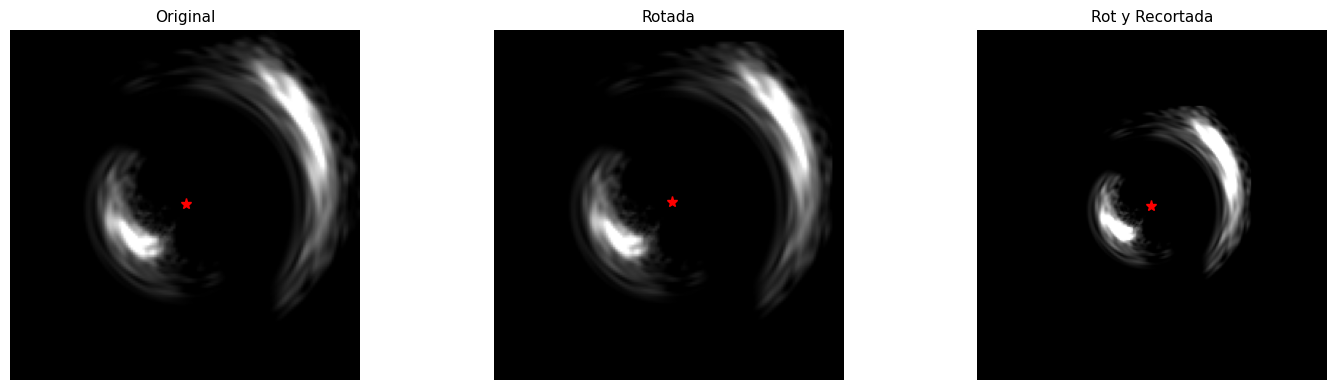

Angle  0


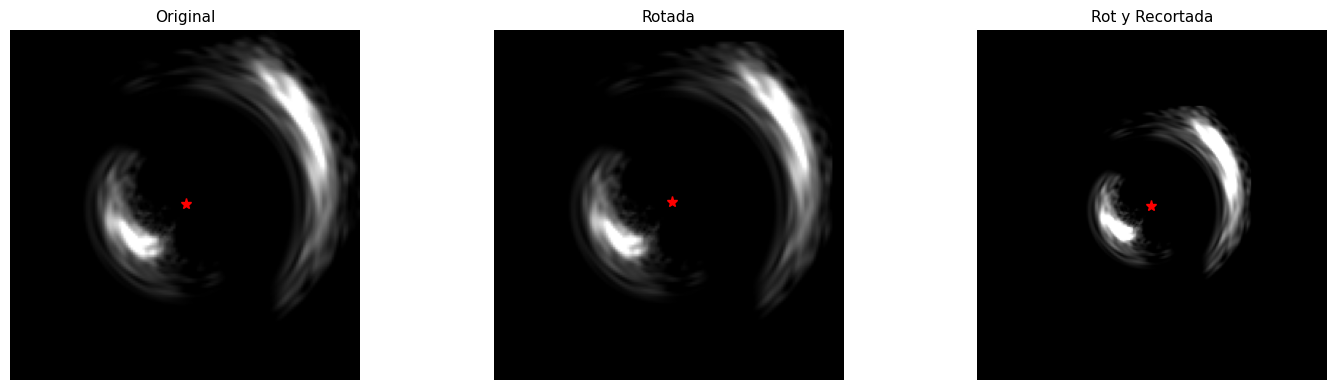

Angle  0


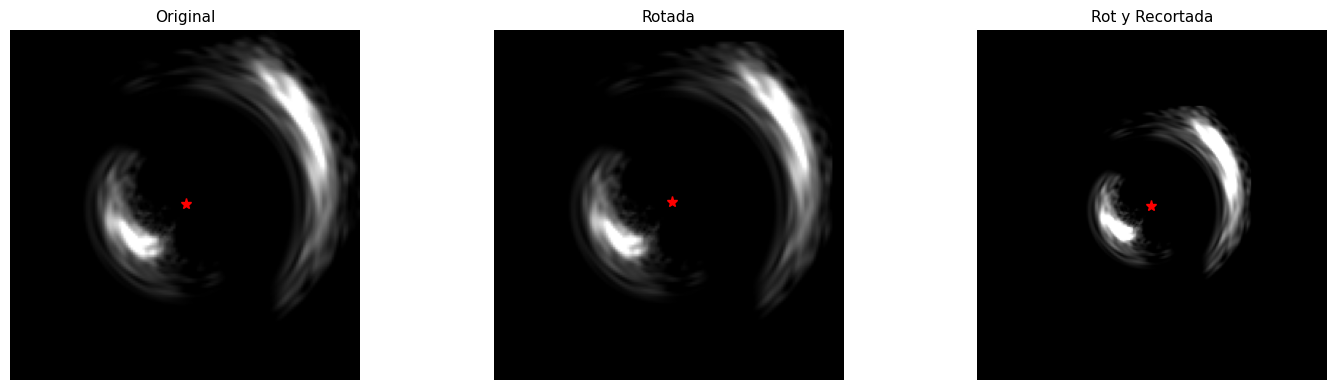

Angle  0


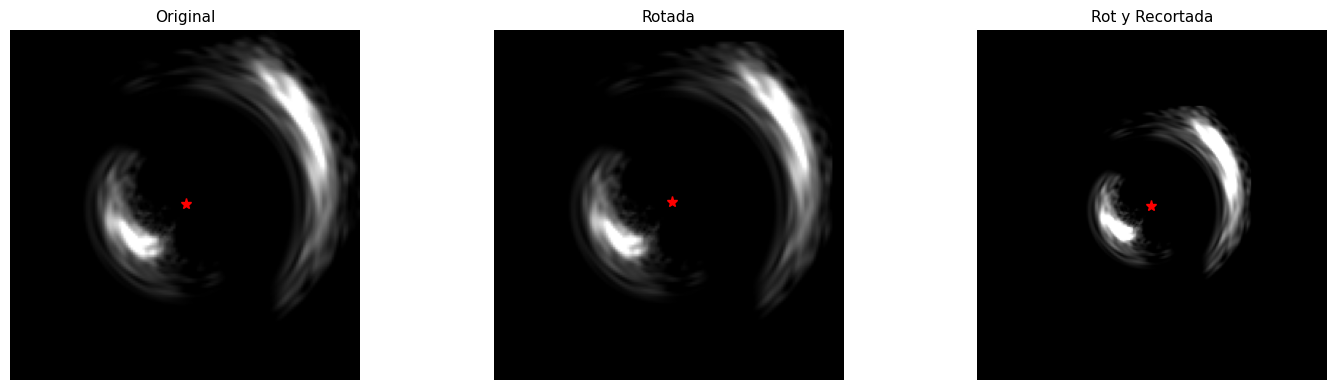

Angle  0


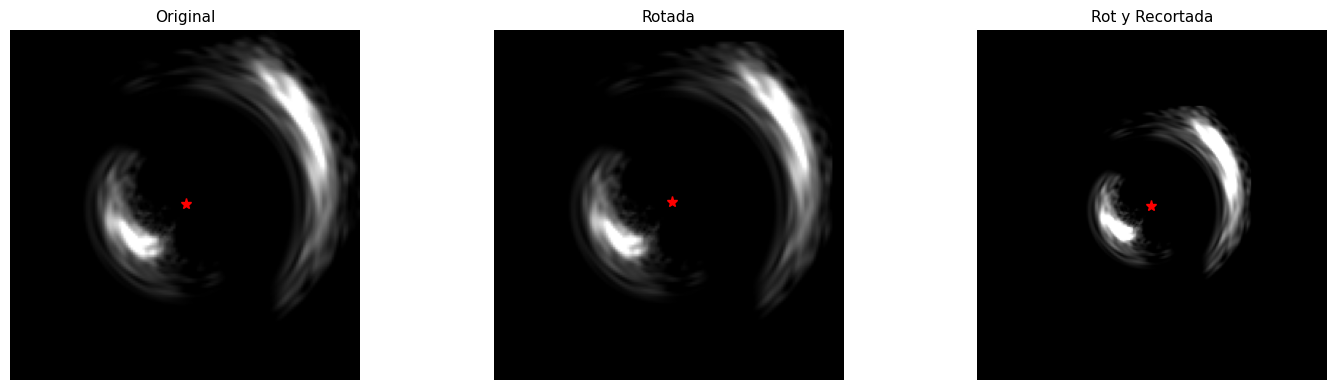

[INFO] Injection complete.


In [24]:
# Rotate stamps, build catalogs, and inject in one loop

rotation_angle_list = [0] * len(rotation_angle_list)
injected_exposures = []
for i, angle in enumerate(rotation_angle_list):
    visit_id = sort_visit_calexp_dataset[i]
    visit_image = butler.get("visit_image", dataId=visit_id)

    # Rotate all stamps for this visit
    print("Angle ", angle)
    rotated_stamps_path = [
        apply_correction_to_stamp(
            stamp_file,
            angle,
            output_path=f"{rot_name_save}_angle_{angle}_stamp_{j}.fits",
            keep_size=False,
            interp_order=3,
            update_wcs=True,  # importante
            c=1,
            from_data=False,  # revisar reajuste de tamaño cuando se usa from data
            warping_kernel='lanczos4',
            radius_pixels=120,  # new
            center_coord=None
        )
        for j, stamp_file in enumerate(stamp_paths)
    ]  # [rotate_stamp1_path, rotate_stamp2_path, ...]

    # Create injection catalog
    inj_cat = vr.create_crowded_injection_catalog(
        ra_list,
        dec_list,
        rotated_stamps_path,
        mags,
        min_sep=0.0005,
        separation_spherical=True
    )

    # Perform injection
    try:
        inj_exp = vr.inject_stamp(visit_image, inj_cat)
        injected_exposures.append(inj_exp)
    except Exception as e:
        print(f"[ERROR] Injection failed for visit {visit_image.getInfo().getVisitInfo().getId()}: {e}")

print("[INFO] Injection complete.")

Rotation of:  0
[INFO] Converted LSST SkyWcs -> Astropy WCS


/home/arestrada88/WORK/Alma_proyect/VeraRubin/plot/injection_plot.py:170: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


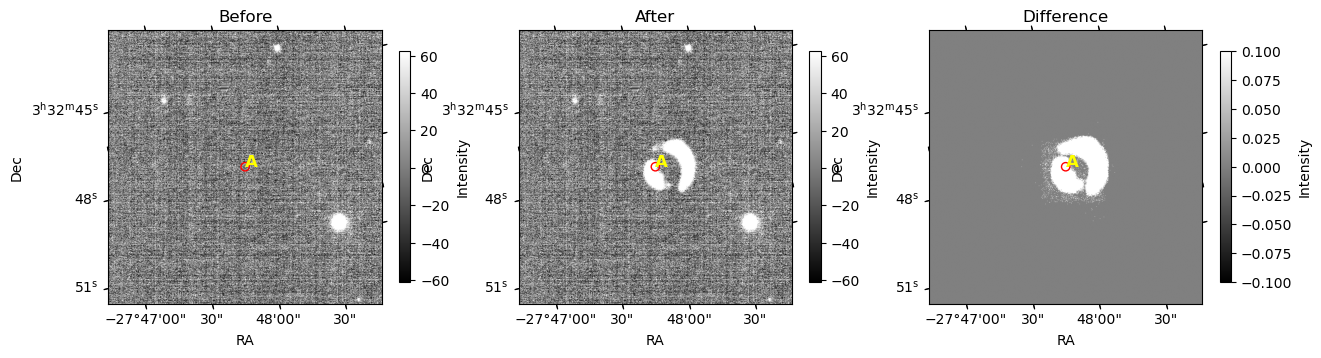

Rotation of:  0
[INFO] Converted LSST SkyWcs -> Astropy WCS


/home/arestrada88/WORK/Alma_proyect/VeraRubin/plot/injection_plot.py:170: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


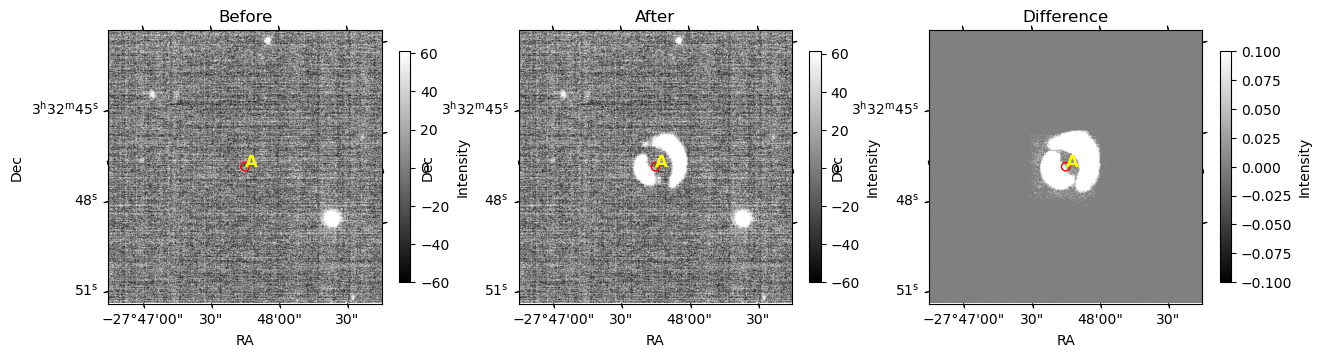

Rotation of:  0
[INFO] Converted LSST SkyWcs -> Astropy WCS


/home/arestrada88/WORK/Alma_proyect/VeraRubin/plot/injection_plot.py:170: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


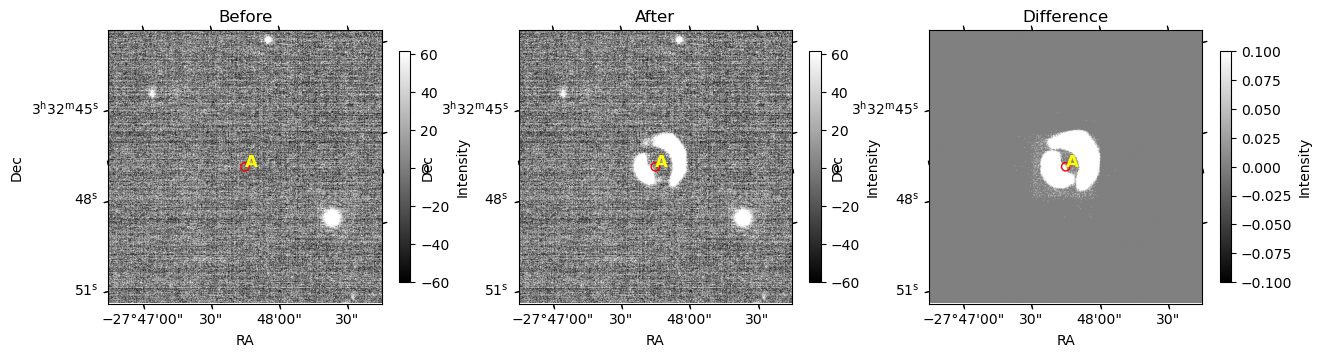

Rotation of:  0
[INFO] Converted LSST SkyWcs -> Astropy WCS


/home/arestrada88/WORK/Alma_proyect/VeraRubin/plot/injection_plot.py:170: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


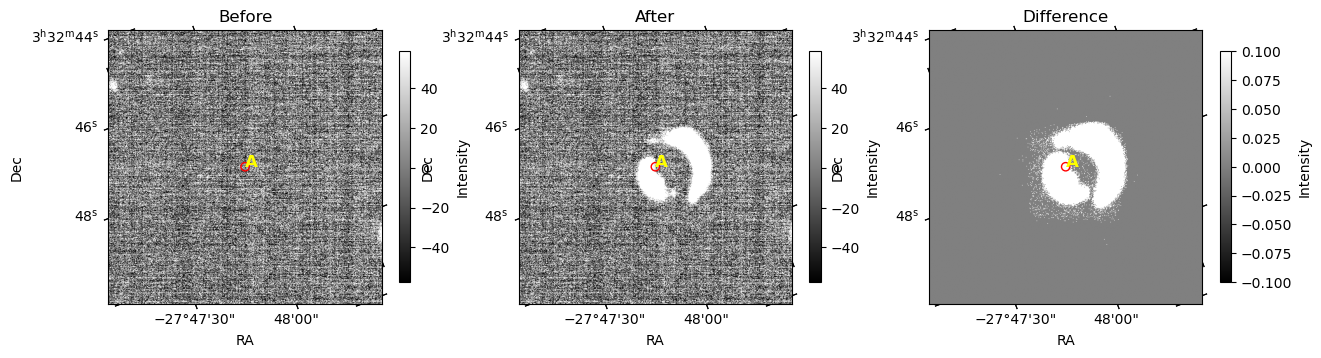

Rotation of:  0
[INFO] Converted LSST SkyWcs -> Astropy WCS


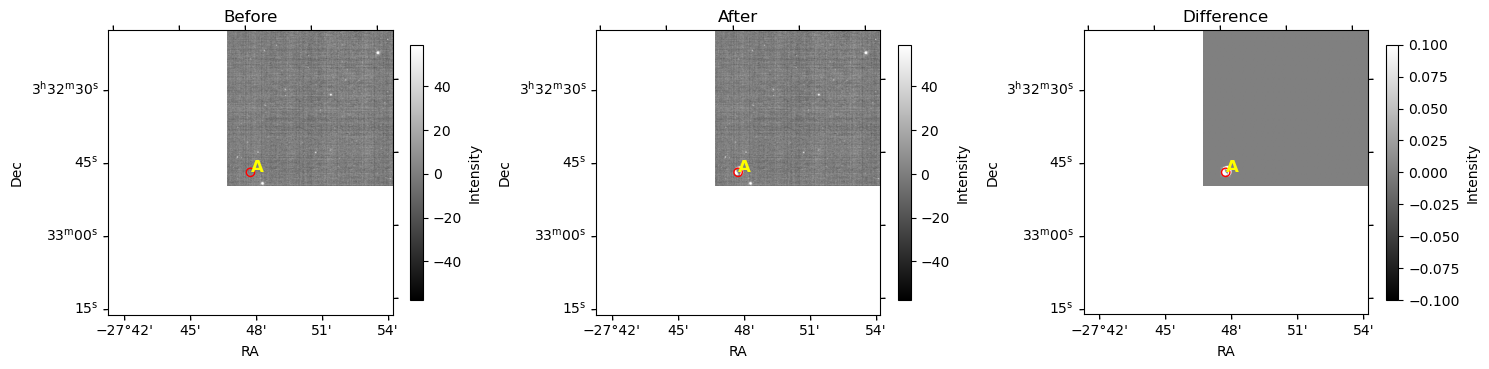

In [25]:
# visualizating full image set

points = [[ra_deg, dec_deg]]
temp = []
for i, angle in enumerate(rotation_angle_list):
    print("Rotation of: ", angle)
    visit_id = sort_visit_calexp_dataset[i]
    before = butler.get("visit_image", dataId=visit_id)
    temp.append(before)
    after = injected_exposures[i]
    vr.injection_steps(before, after, points,
                       diference=True,
                       cutout_radius_arcsec=15,  # arcsec  10
                       grid=False, percentiles=[5, 95])

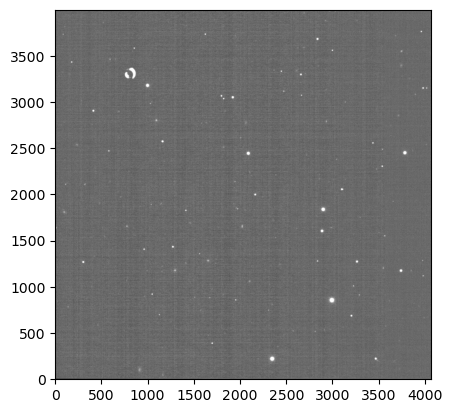

In [26]:
# Visualizating the referential image
img = injected_exposures[0].getImage().getArray()

p5, p95 = np.nanpercentile(img, [0.01, 99.9])
plt.imshow(img, origin='lower', cmap='gray', vmin=p5, vmax=p95)

In [28]:
def warp_img(ref_img, img_to_warp, ref_wcs, wcs_to_warp):
    from lsst.pipe.tasks.registerImage import RegisterConfig, RegisterTask

    config = RegisterConfig()
    task = RegisterTask(name="register", config=config)
    warpedExp = task.warpExposure(img_to_warp, wcs_to_warp, ref_wcs,
                                  ref_img.getBBox())

    return warpedExp

In [29]:
wcs1 = injected_exposures[0].getWcs()

img_warped1 = warp_img(injected_exposures[0], injected_exposures[1], wcs1, injected_exposures[1].getWcs())
img_warped2 = warp_img(injected_exposures[0], injected_exposures[2], wcs1, injected_exposures[2].getWcs())
img_warped3 = warp_img(injected_exposures[0], injected_exposures[3], wcs1, injected_exposures[3].getWcs())
img_warped4 = warp_img(injected_exposures[0], injected_exposures[4], wcs1, injected_exposures[4].getWcs())

In [30]:
import lsst.afw.display as afwDisplay
afwDisplay.setDefaultBackend('matplotlib')

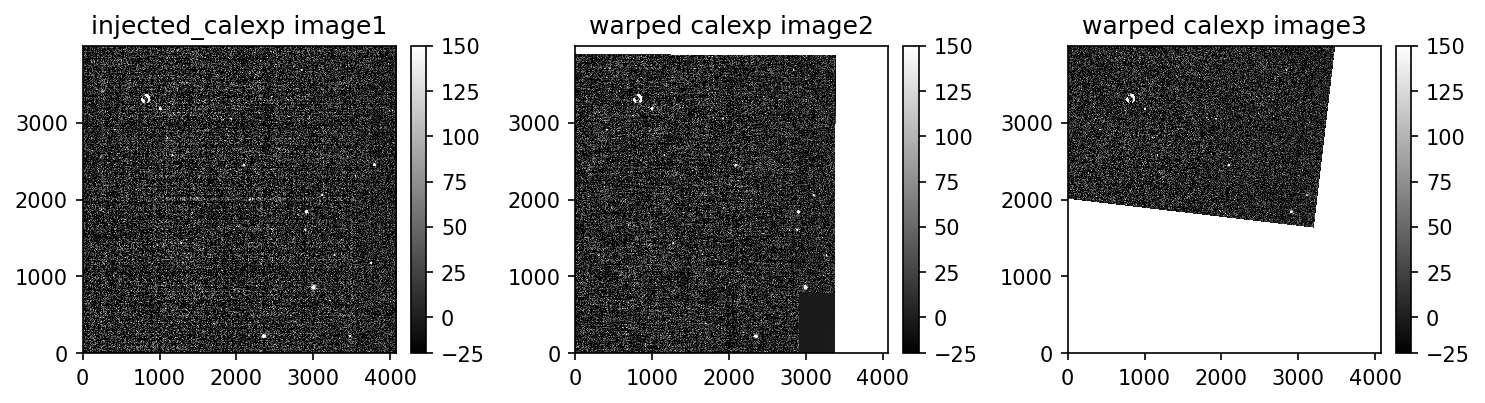

In [31]:
plot_warped_calexp2 = img_warped2.clone()
plot_warped_calexp3 = img_warped3.clone()

fig, ax = plt.subplots(1, 3, figsize=(10, 6), dpi=150)

plt.sca(ax[0])
display0 = afwDisplay.Display(frame=fig)
# display0.scale('linear', 'zscale')
display0.scale('linear', min=-20, max=150)
display0.mtv(injected_exposures[0].image)
plt.title('injected_calexp image1')

plt.sca(ax[1])
display1 = afwDisplay.Display(frame=fig)
# display1.scale('linear', 'zscale')
display1.scale('linear', min=-20, max=150)
display1.mtv(plot_warped_calexp2.image)
plt.title('warped calexp image2')

plt.sca(ax[2])
display2 = afwDisplay.Display(frame=fig)
# display1.scale('linear', 'zscale')
display2.scale('linear', min=-20, max=150)
display2.mtv(plot_warped_calexp3.image)
plt.title('warped calexp image3')

plt.tight_layout()
plt.show()

### Making a coadd 

[INFO] Starting coaddition of 5 exposures...
Warp 1: 0.000% NaN pixels
Offset (degree): 0.0
Rotation angle (degree): 4.185715421596676e-16
→ Total diff: 0.0 Max: 0.0 Min: 0.0


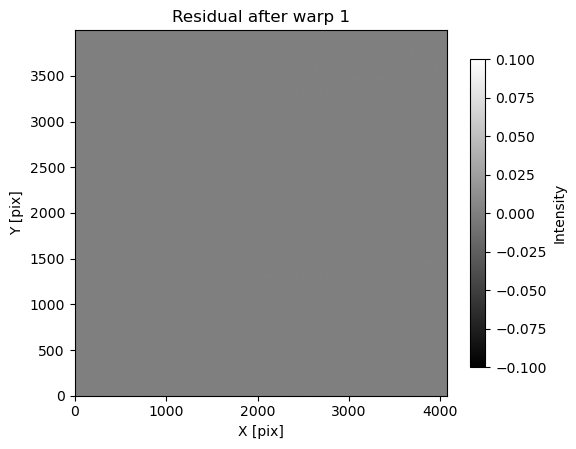

[1/5] exposure coadded.
Warp 2: 67.605% NaN pixels
Offset (degree): 0.13905519505600952
Rotation angle (degree): 0.37983940543739286
→ Total diff: -37356304.0 Max: 153173.77 Min: 0.0


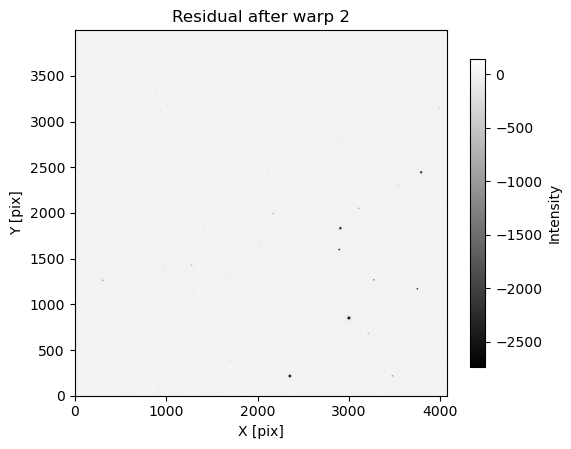

[2/5] exposure coadded.
Warp 3: 19.761% NaN pixels
Offset (degree): 0.03925728190509938
Rotation angle (degree): 0.36919504542176534
→ Total diff: -5748203.5 Max: 34393.26 Min: 0.0


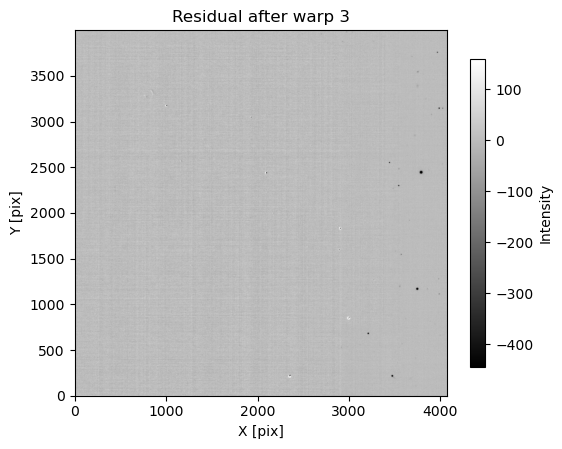

[3/5] exposure coadded.
Warp 4: 55.236% NaN pixels
Offset (degree): 0.10882259244543235
Rotation angle (degree): 353.3704979568793
→ Total diff: -31734154.0 Max: 153173.77 Min: 0.0


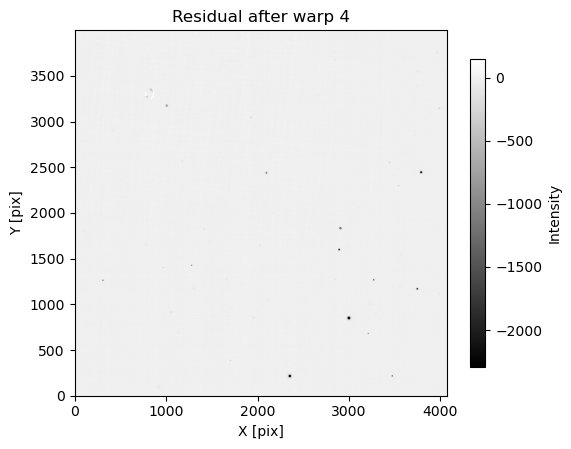

[4/5] exposure coadded.
Warp 5: 86.560% NaN pixels
Offset (degree): 0.18980031978158282
Rotation angle (degree): 12.171780591654432
→ Total diff: -41030830.0 Max: 153173.77 Min: 0.0


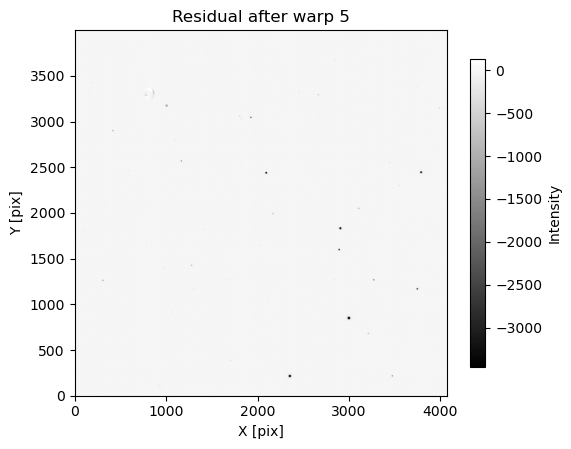

[5/5] exposure coadded.
[INFO] LSST-style coadd saved to ./coadds_test_notebook/band_u_coadd_test3.fits
[INFO] Coverage map saved to ./coadds_test_notebook/coverage_map.fits
Coaddition complete.
Pixels with no coverage: 0 / 16288000


In [32]:

coadded_exp, coverage_map = vr.coadd_exposures_pipeline(
    injected_exposures,  # temp[:2], 
    ref_exp=None,
    warping_kernel="lanczos4",  # "lanczos3"
    save_path="./coadds_test_notebook",
    coadd_name=f"band_{band}_coadd_test3.fits",
    info=True,
    plot_debug=True,
    same_check=True
    )

In [33]:
# Loading the Exposure Coadd
from lsst.afw.image import ExposureF

coadd_exp = ExposureF.readFits(f"./coadds_test_notebook/band_{band}_coadd_test3.fits")

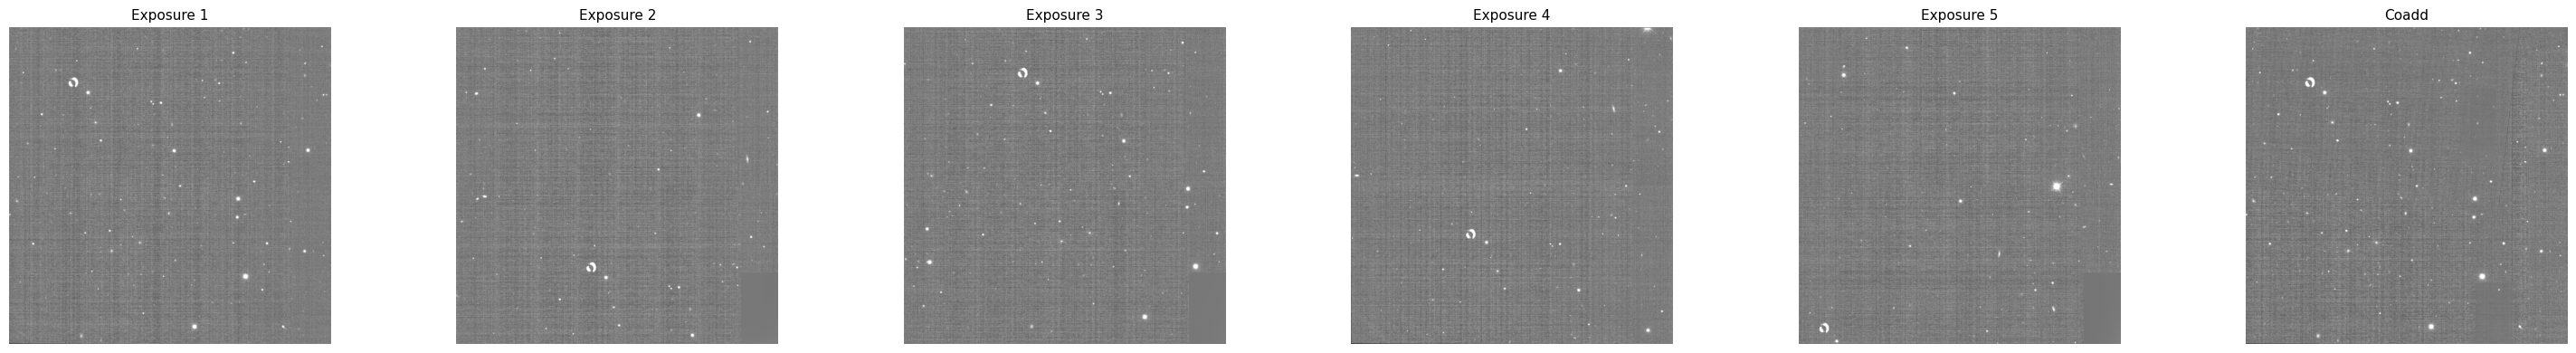

In [35]:
# Visualizing the result 
vr.plot_exposures_full(injected_exposures,
                         coadded_exp,
                         exposures_scale='percentile', # 'zscale_asinh',
                         coadd_exp_scale='percentile', # 'percentile' zscale_asinh
                         show_second_row=False,
                         save_path=None)

[INFO] Converted LSST SkyWcs -> Astropy WCS


/home/arestrada88/WORK/Alma_proyect/VeraRubin/plot/injection_plot.py:170: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


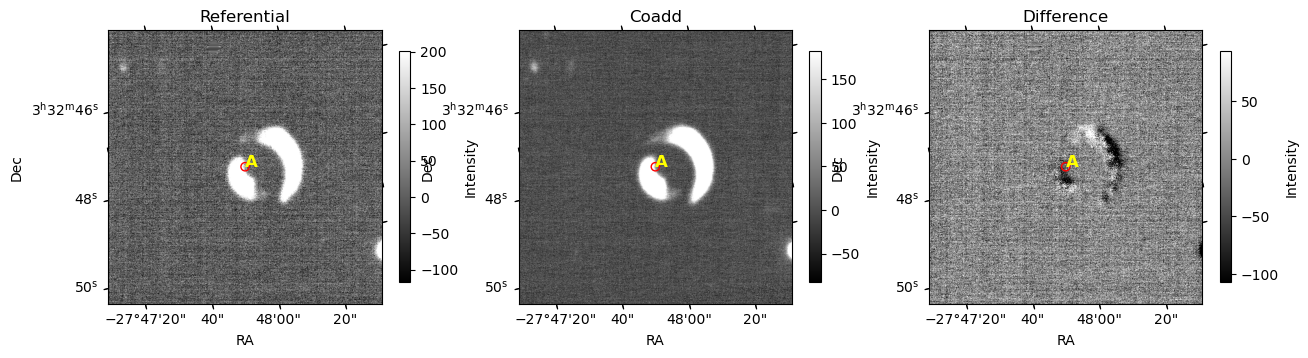

In [36]:
vr.injection_steps(
    injected_exposures[0],
    coadd_exp,
    points,
    diference=True,
    cutout_radius_arcsec=10,  # arcsec points
    grid=False, percentiles=[0.1, 99.9], #[5, 95]
    names=['Referential', 'Coadd', 'Difference'])

[INFO] Converted LSST SkyWcs -> Astropy WCS


/home/arestrada88/WORK/Alma_proyect/VeraRubin/plot/injection_plot.py:170: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


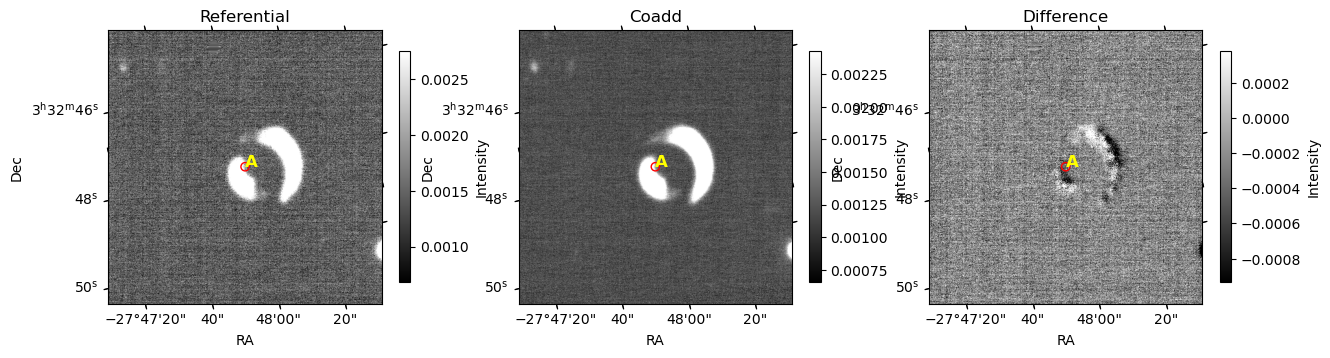

In [37]:
# Repeating the same plot, but now, rescaling the intensity of each image independently to [0,1]

exp_ref_norm, exp_coadd_norm = vr.normalize_exposures(
    injected_exposures[0],
    coadd_exp,
    method="rescale")

vr.injection_steps(
    exp_ref_norm,
    exp_coadd_norm,
    points,
    diference=True,
    cutout_radius_arcsec=10,  # arcsec points
    grid=False, percentiles=[0.1, 99.9], #[5, 95]
    names=['Referential', 'Coadd', 'Difference'])

[INFO] Converted LSST SkyWcs -> Astropy WCS


/home/arestrada88/WORK/Alma_proyect/VeraRubin/plot/injection_plot.py:170: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


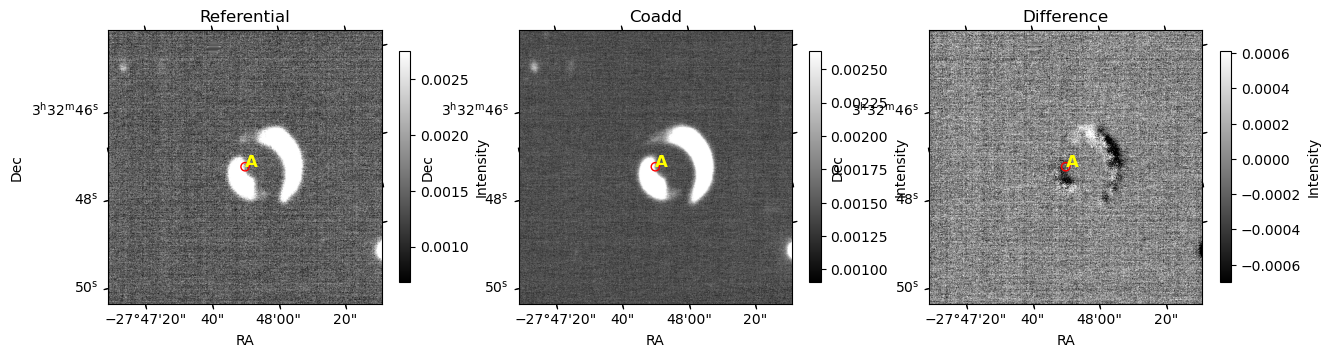

In [38]:
# Repeating the same plot, but now, rescaling both using the global min and max

exp_ref_Gnorm, exp_coadd_Gnorm = vr.normalize_exposures(
    injected_exposures[0],
    coadd_exp,
    method="global_rescale")

vr.injection_steps(
    exp_ref_Gnorm,
    exp_coadd_Gnorm,
    points,
    diference=True,
    cutout_radius_arcsec=10,  # arcsec points
    grid=False, percentiles=[0.1, 99.9], #[5, 95]
    names=['Referential', 'Coadd', 'Difference'])

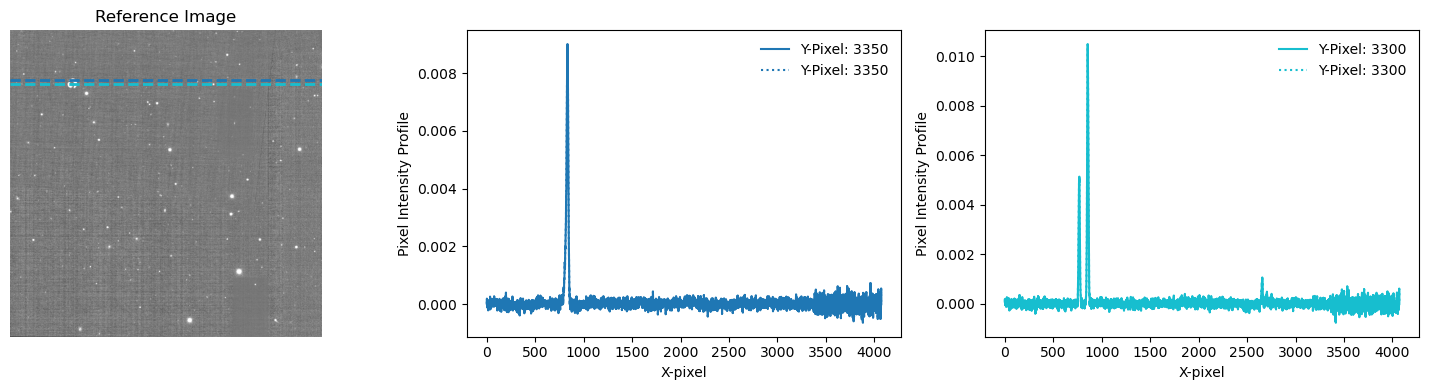

In [39]:
# Pixel plot normalized to the max pixel intensity
y_positions_pixel = [3350, 3300]
image_array_list = [coadd_exp.image.array, coadd_exp.image.array]
vr.pixel_intensity(image_array_list, y_positions_pixel, image_ref=True,
                    save_path=None, colormap='tab10')